# Mixscape

This vignette reproduces the Mixscape https://satijalab.org/seurat/articles/mixscape_vignette.html
We demonstrate that pertpy can reproduce the results and go beyond Mixscape.

Reference: Papalexi, E., Mimitou, E.P., Butler, A.W. et al. Characterizing the molecular regulation of inhibitory immune checkpoints with multimodal single-cell screens. Nat Genet 53, 322–331 (2021). https://doi.org/10.1038/s41588-021-00778-2

In [1]:
import pertpy as pt
import muon as mu
import pandas as pd
import scanpy as sc

Installed version 0.4.0 of pertpy is newer than the latest release 0.3.0! You are running a nightly version and 
features may break!

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

# Getting the dataset

Download a 111 gRNA ECCITE-seq dataset generated from stimulated THP-1 cells that was published in bioRxiv https://www.biorxiv.org/content/10.1101/2020.06.28.175596v1

In [2]:
mdata = pt.dt.papalexi_2021()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━  84% 0:00:56
Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━  84% 0:00:56

In [3]:
mdata

MuData object with n_obs × n_vars = 20729 × 18776
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    hto:	20729 x 12
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    gdo:	20729 x 111
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'

# Preprocessing

## RNA

In [4]:
mdata["rna"]

AnnData object with n_obs × n_vars = 20729 × 18649
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

In [5]:
sc.pp.normalize_total(mdata['rna'])

In [6]:
sc.pp.log1p(mdata['rna'])

In [7]:
sc.pp.highly_variable_genes(mdata['rna'], subset=True)

## Protein

In [8]:
mdata["adt"]

AnnData object with n_obs × n_vars = 20729 × 4
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

In [9]:
mu.prot.pp.clr(mdata["adt"])

# RNA-based clustering is driven by confounding sources of variation

Cluster cells based on their gene expression profiles. We expect perturbation-specific clusters, but as we can see, from the UMAP plots, the clustering is primarily driven by cell cycle phase and replicate ID.

In [10]:
sc.pp.pca(mdata["rna"])

In [11]:
sc.pp.neighbors(mdata['rna'], metric='cosine')

In [12]:
sc.tl.umap(mdata["rna"])

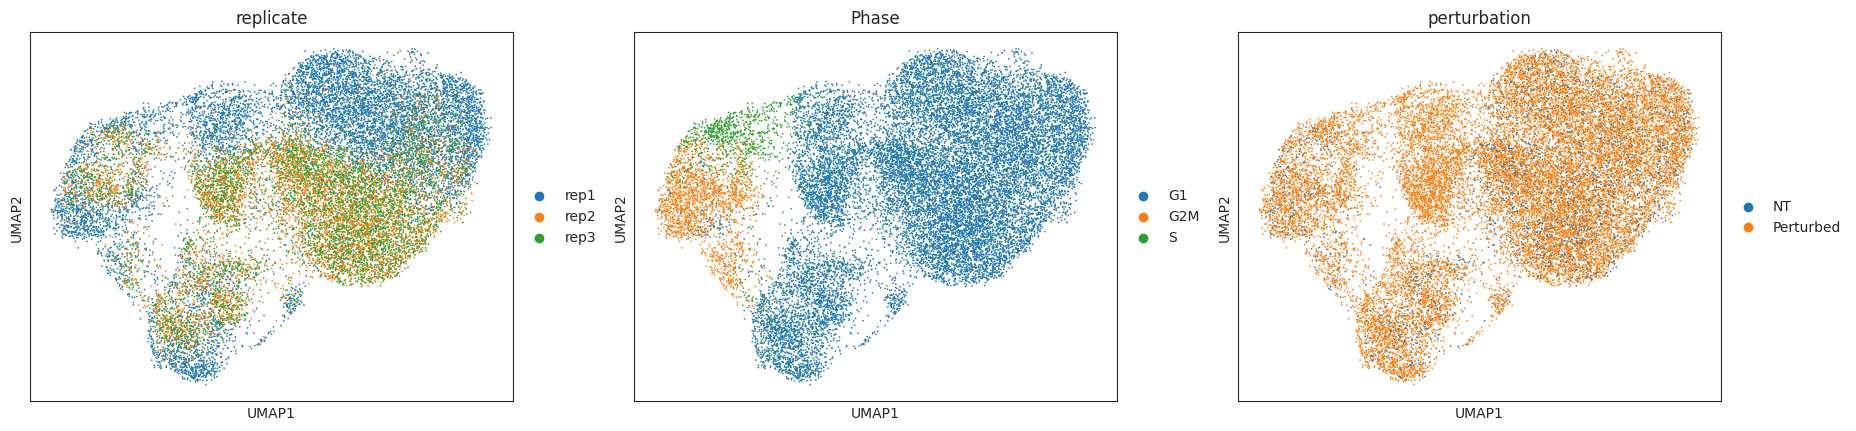

In [13]:
sc.pl.umap(mdata["rna"], color=["replicate", "Phase", "perturbation"])

# Calculating local perturbation signatures mitigates confounding effects

Calculate perturbation signature. For each cell, we identify n_neighbors cells from the control pool with the most similar mRNA expression profiles. The perturbation signature is calculated by subtracting the averaged mRNA expression profile of the control neighbors from the mRNA expression profile of each cell.

In [14]:
mixscape_identifier = pt.tl.Mixscape()
mixscape_identifier.perturbation_signature(mdata['rna'], 'perturbation', 'NT', 'replicate')

In [15]:
adata_pert = mdata['rna'].copy()

In [16]:
adata_pert.X = adata_pert.layers['X_pert']

In [17]:
sc.pp.pca(adata_pert)

In [18]:
sc.pp.neighbors(adata_pert, metric='cosine')

In [19]:
sc.tl.umap(adata_pert)

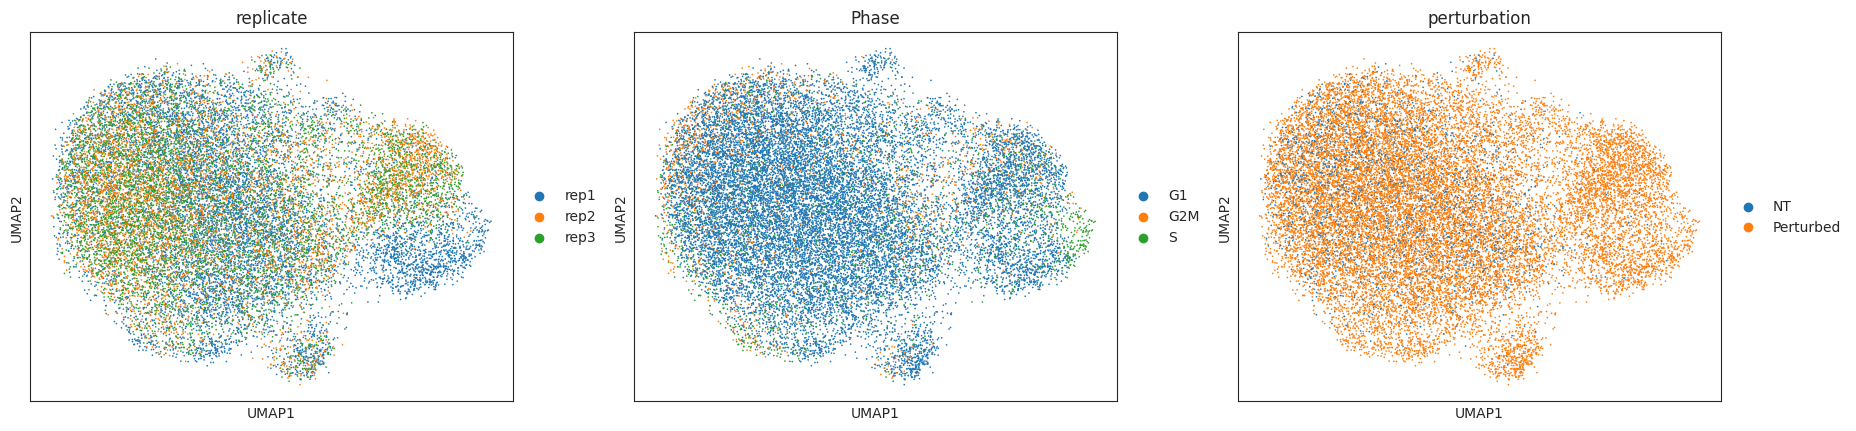

In [20]:
sc.pl.umap(adata_pert, color=['replicate', 'Phase', 'perturbation'])

# Mixscape identifies cells with no detectable perturbation

Identify perturbed and non-perturbed gRNA expressing cells that accounts for multiple perturbations.

In [21]:
mixscape_identifier.mixscape(adata = mdata['rna'], control = 'NT', labels='gene_target', layer='X_pert')

We detect variation in gRNA targeting efficiency within each class.

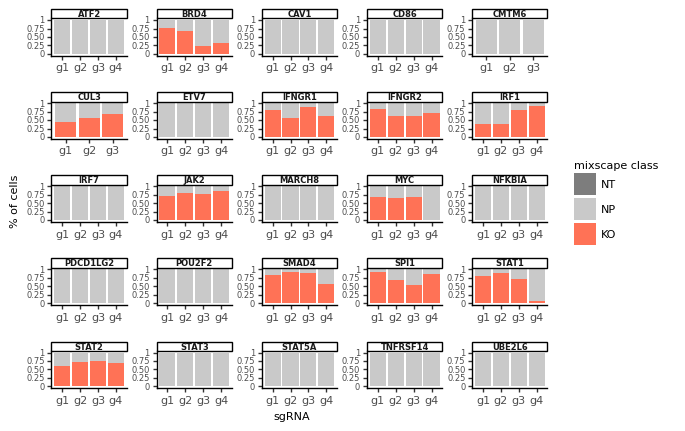

<ggplot: (8778233962472)>

In [22]:
pt.pl.ms.barplot(mdata['rna'], guide_rna_column='NT')

# Inspecting mixscape results

Explore the perturbation scores of cells.

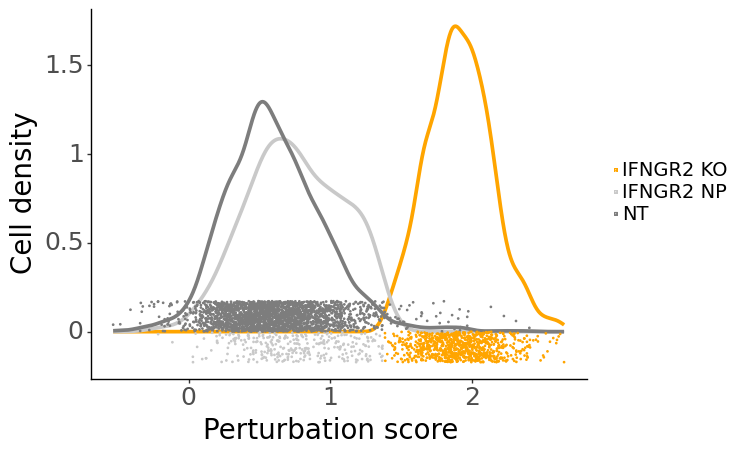

<ggplot: (8778237542959)>

In [23]:
pt.pl.ms.perturbscore(adata = mdata['rna'], labels='gene_target', target_gene='IFNGR2', color = 'orange')

Inspect the posterior probability values in NP and KO cells.

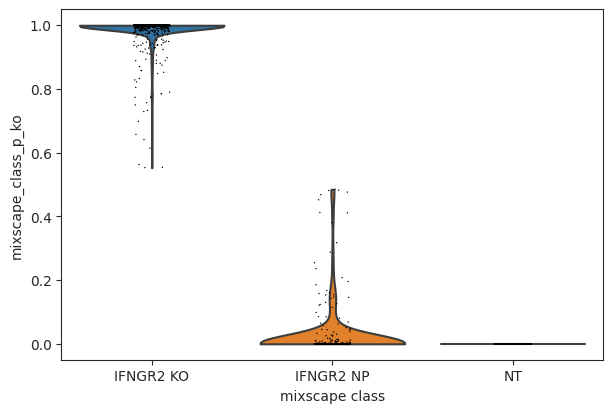

In [24]:
pt.pl.ms.violin(adata = mdata['rna'], target_gene_idents=['NT', 'IFNGR2 NP', 'IFNGR2 KO'], groupby='mixscape_class')

Run DE analysis and visualize results on a heatmap ordering cells by their posterior probability values.

categories: IFNGR2 KO, IFNGR2 NP, NT
var_group_labels: NT


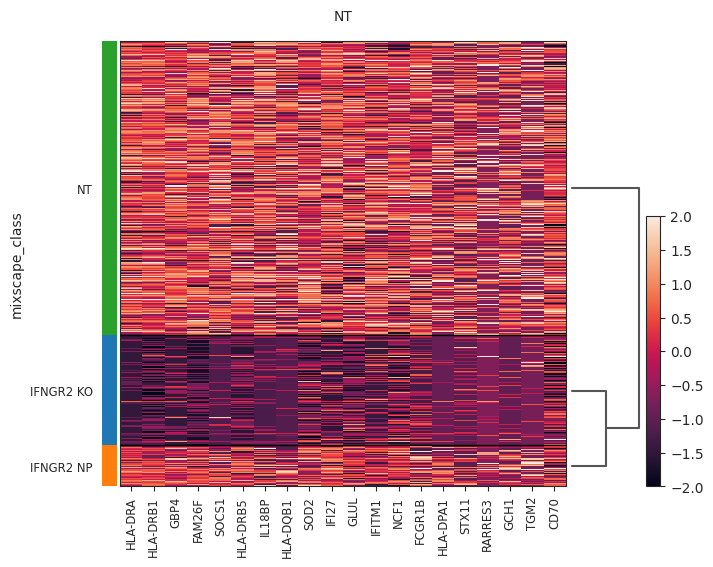

In [25]:
pt.pl.ms.heatmap(adata = mdata['rna'], labels='gene_target', target_gene='IFNGR2', layer='X_pert', control='NT')

Show that only IFNG pathway KO cells have a reduction in PD-L1 protein expression.

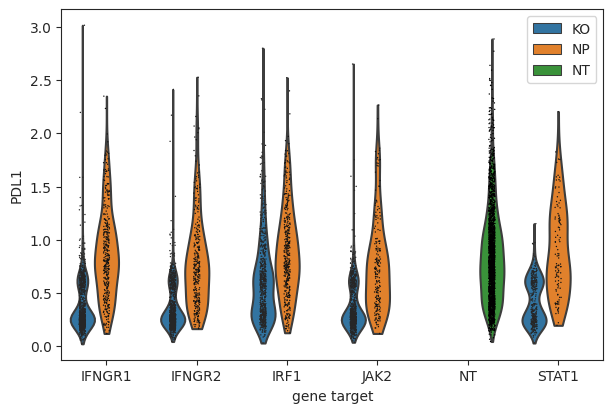

In [26]:
mdata['adt'].obs['mixscape_class_global'] = mdata['rna'].obs['mixscape_class_global']
pt.pl.ms.violin(adata = mdata['adt'], target_gene_idents=["NT","JAK2","STAT1","IFNGR1","IFNGR2", "IRF1"], keys='PDL1', groupby='gene_target', hue='mixscape_class_global')

# Visualizing perturbation responses with Linear Discriminant Analysis (LDA)

Use LDA as a dimensionality reduction method to visualize perturbation-specific clusters. LDA is trying to maximize the separability of known labels (mixscape classes) using both gene expression and the labels as input.

In [27]:
mixscape_identifier = pt.tl.Mixscape()
mixscape_identifier.lda(adata=mdata['rna'], labels='gene_target', layer='X_pert')

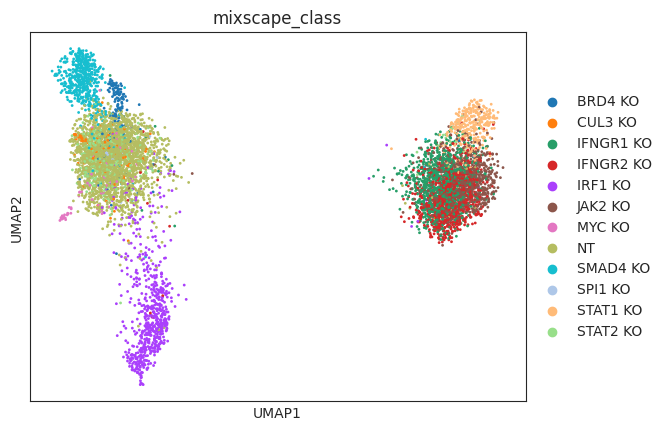

In [28]:
pt.pl.ms.lda(adata=mdata['rna'])